In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
# from tqdm import tqdm
# import time
# import copy

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns

# importing the statistics module
import statistics

import joblib

In [2]:
# # tn, fp, fn, tp = each_index(cm)
def each_index(metrix):
    TN = metrix[0][0]
    FP = metrix[0][1]
    FN = metrix[1][0]
    TP = metrix[1][1]
    return TN, FP, FN, TP
def sensitivity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate sensitivity
    sensitivity = TP / (TP + FN) * 100
    print("Sensitivity: %.2f%%" % sensitivity)
    return sensitivity
def specificity(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate specificity
    specificity = TN / (TN + FP) * 100
    print("Specificity: %.2f%%" % specificity)
    return specificity
def accuracy(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    accuracy = ((TP + TN) / (TP + TN + FP + FN)) *100
    print("Accuracy: %.2f%%" % accuracy)
    return accuracy
def precision(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate accuracy
    precision = (TP / (TP + FP)) *100
    print("Precision: %.2f%%" % precision)
    return precision
def f1(metrix):
    TN, FP, FN, TP = each_index(metrix)
    # Calculate f1
    recall = sensitivity(metrix)
    pre = precision(metrix)
    f1 = ((2*pre*recall) / (pre+recall))
    print("F1: %.2f%%" % f1)
    return f1


In [43]:
def evaluate(param,split):
    loaded_model = joblib.load('rf_model_Final/rf_param{}_{}.joblib'.format(param,split))
    ############## validate set ################
    print("############## validate set ################")
    y_pred_val = loaded_model.predict(x_val)

    # Confusion matrix
    cm_val = confusion_matrix(y_val, y_pred_val)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_val,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_val = sensitivity(cm_val)
    spec_val = specificity(cm_val)
    acc_val = accuracy(cm_val)
    pre_val = precision(cm_val)
    f1_score_val = f1(cm_val)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black")
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()
    # ################# test set ##################
    label = ['benign','malignant']
    print("################# test set ##################")
    y_pred_test = loaded_model.predict(x_test)
    # Print the predictions
    # print(y_pred)

    # Confusion matrix
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('Confusion Matrix')
    print('-'*16)
    print(cm_test,'\n')
    print('-'*16)

    # Calculate score
    print(split)
    sen_test = sensitivity(cm_test)
    spec_test = specificity(cm_test)
    acc_test = accuracy(cm_test)
    pre_test = precision(cm_test)
    f1_score_test = f1(cm_test)

    # plot confusion matrix
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_test, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_test.shape[1]),
           yticks=np.arange(cm_norm_test.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Test set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_test.max() / 2.
    for i in range(cm_norm_test.shape[0]):
        for j in range(cm_norm_test.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_test[i,j], cm_norm_test[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_test[i, j] > thresh else "black")

    plt.show()

    ################## plot ROC curve ########################
    fpr1, tpr1, thr1 = metrics.roc_curve(y_val,  y_pred_val)
    auc1 = metrics.roc_auc_score(y_val,  y_pred_val)
    fpr2, tpr2, thr2 = metrics.roc_curve(y_test,  y_pred_test)
    auc2 = metrics.roc_auc_score(y_test,  y_pred_test)
    gmeans2 = np.sqrt(tpr2 * (1-fpr2))
    ix2 = np.argmax(gmeans2)
    print("---------------------------------------")
    print("AUC validate: %.4f" % auc1)
    print("AUC test: %.4f" % auc2)
    plt.plot(fpr1,tpr1,label="ROC valid, auc="+str("%.4f" % auc1))
    plt.plot(fpr2,tpr2,label="ROC test, auc="+str("%.4f" % auc2))
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    plt.legend(loc=4)
    plt.show()
    return cm_val,cm_test,auc_val,auc_test


In [4]:
def setup(split):
    # setting split and path
    split = 'split1'
    path = "../Anny_oversampling/DATA/"
    train_path = "{}/{}/train/oversampled_train_{}.csv".format(path,split,split)
    # test_path =  "{}/{}/test/test_{}.csv".format(path,split,split)
    test_path =  "{}/test.csv".format(path)
    valid_path = "{}/{}/val/val_{}.csv".format(path,split,split)

    print(train_path)
    # Load the train set
    train_data = pd.read_csv(train_path)
    print(train_data.shape)
    x_train = train_data[train_data.columns[2:]]
    print(x_train.shape)
    y_train = train_data[train_data.columns[1]]
    le = LabelEncoder()
    y_train = np.array(le.fit_transform(y_train))
    print(le.classes_)
    print(test_path)
    # Load the test set
    test_data = pd.read_csv(test_path)
    print(test_data.shape)
    x_test = test_data[test_data.columns[3:]]
    print(x_test.shape)
    y_test = test_data[test_data.columns[2]]
    le = LabelEncoder()
    y_test = np.array(le.fit_transform(y_test))
    print(le.classes_)

    print(valid_path)
    # Load the validation set
    val_data = pd.read_csv(valid_path)
    print(val_data.shape)
    x_val = val_data[val_data.columns[2:]]
    print(x_val.shape)
    y_val = val_data[val_data.columns[1]]
    le = LabelEncoder()
    y_val = np.array(le.fit_transform(y_val))
    print(le.classes_)

    # StandardScaler
    sc = StandardScaler()
    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    x_val = x_val.to_numpy()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    x_val = sc.transform(x_val)
    
    return x_train,y_train,x_test,y_test,x_val,y_val

In [5]:
# #1
# cv_rf1 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=4, max_features='log2', min_samples_leaf=1, min_samples_split=5, n_estimators=130)
# #2
# cv_rf2 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=6, max_features='sqrt', min_samples_leaf=3, min_samples_split=7, n_estimators=120)
# #3
# cv_rf3 = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=130)
# #4
# cv_rf4 = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=120)
# #5
# cv_rf5 = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=6, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=130)

# Setting Split 1

In [6]:
split_num = 1
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../Anny_oversampling/DATA//split1/train/oversampled_train_split1.csv
(518, 32)
(518, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']
../Anny_oversampling/DATA//split1/val/val_split1.csv
(91, 32)
(91, 30)
['B' 'M']


## param1 split1

############## validate set ################
Confusion Matrix
----------------
[[50  2]
 [ 3 36]] 

----------------
split1
Sensitivity: 92.31%
Specificity: 96.15%
Accuracy: 94.51%
Precision: 94.74%
Sensitivity: 92.31%
Precision: 94.74%
F1: 93.51%


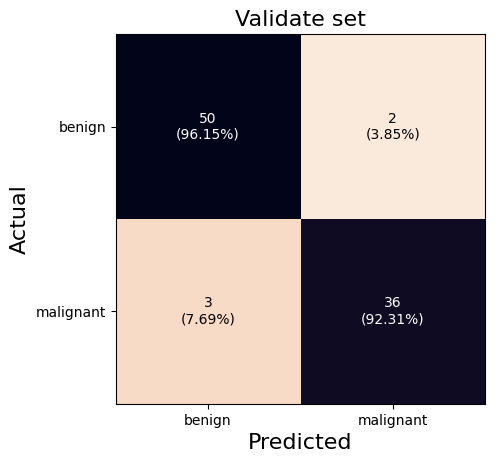

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 6 62]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 97.83%
Accuracy: 93.86%
Precision: 98.41%
Sensitivity: 91.18%
Precision: 98.41%
F1: 94.66%


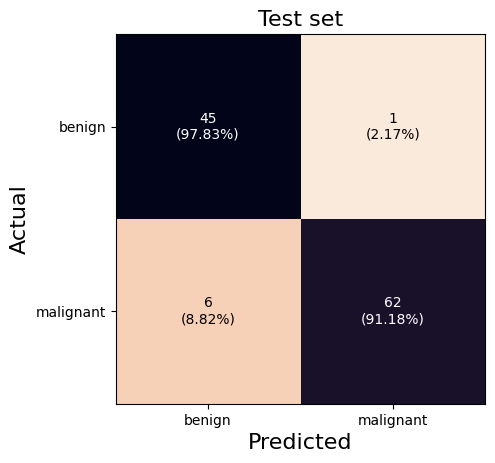

---------------------------------------
AUC validate: 0.9423
AUC test: 0.9450


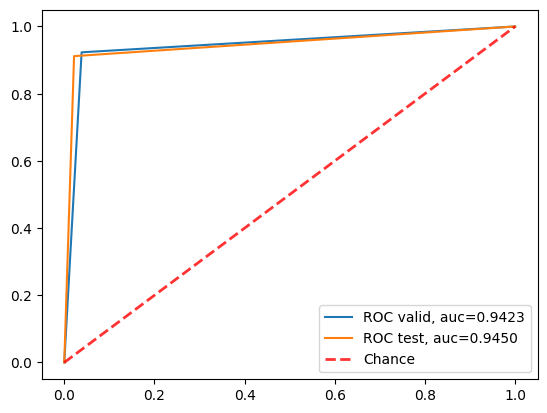

In [7]:
param = 1
param1_split1_cm_val, param1_split1_cm_test, param1_split1_AUC_val, param1_split1_AUC_test = evaluate(param,split)

## param2 split1

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 3 36]] 

----------------
split1
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%


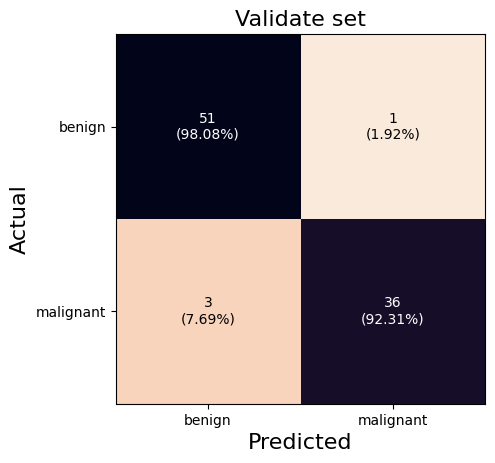

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 6 62]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 95.65%
Accuracy: 92.98%
Precision: 96.88%
Sensitivity: 91.18%
Precision: 96.88%
F1: 93.94%


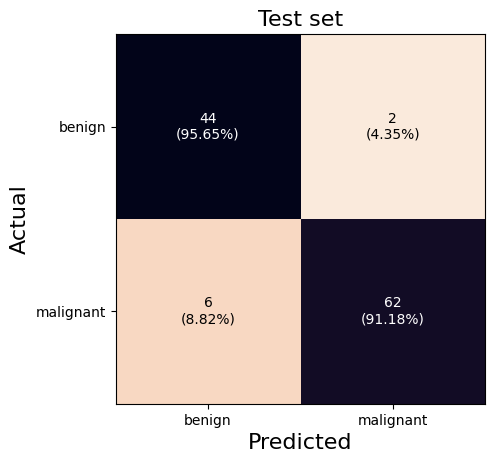

---------------------------------------
AUC validate: 0.9519
AUC test: 0.9341


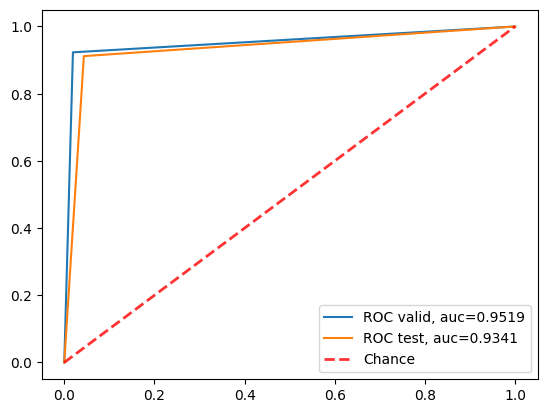

In [8]:
param = 2
param2_split1_cm_val, param2_split1_cm_test, param2_split1_AUC_val, param2_split1_AUC_test = evaluate(param,split)

## param3 split1

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 3 36]] 

----------------
split1
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%


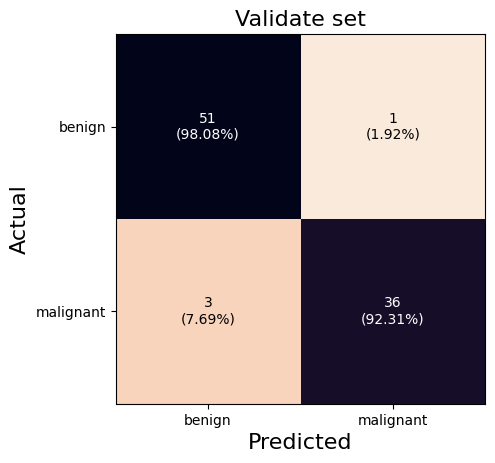

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 6 62]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 97.83%
Accuracy: 93.86%
Precision: 98.41%
Sensitivity: 91.18%
Precision: 98.41%
F1: 94.66%


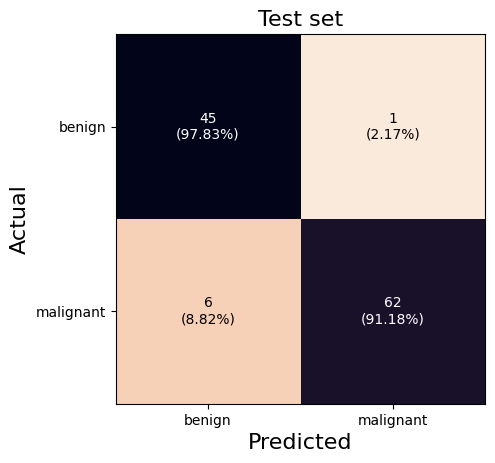

---------------------------------------
AUC validate: 0.9519
AUC test: 0.9450


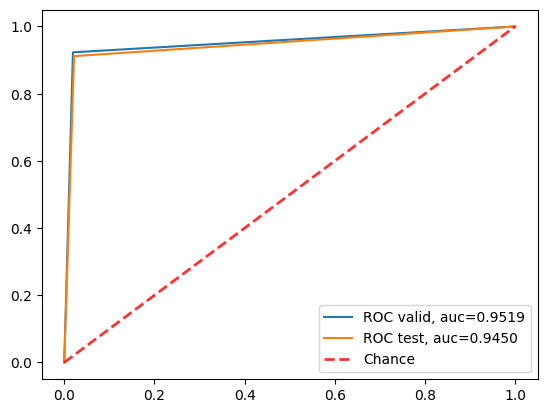

In [9]:
param = 3
param3_split1_cm_val, param3_split1_cm_test, param3_split1_AUC_val, param3_split1_AUC_test = evaluate(param,split)

## param4 split1

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 4 35]] 

----------------
split1
Sensitivity: 89.74%
Specificity: 98.08%
Accuracy: 94.51%
Precision: 97.22%
Sensitivity: 89.74%
Precision: 97.22%
F1: 93.33%


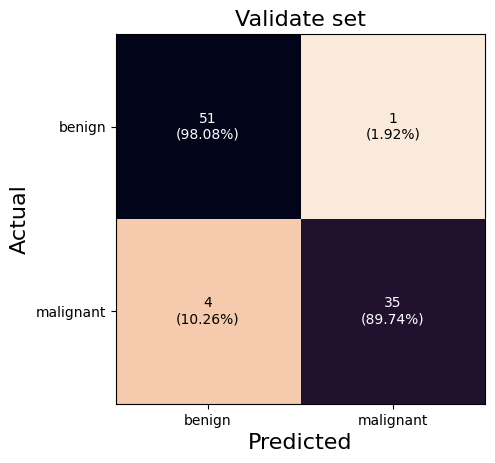

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 6 62]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 97.83%
Accuracy: 93.86%
Precision: 98.41%
Sensitivity: 91.18%
Precision: 98.41%
F1: 94.66%


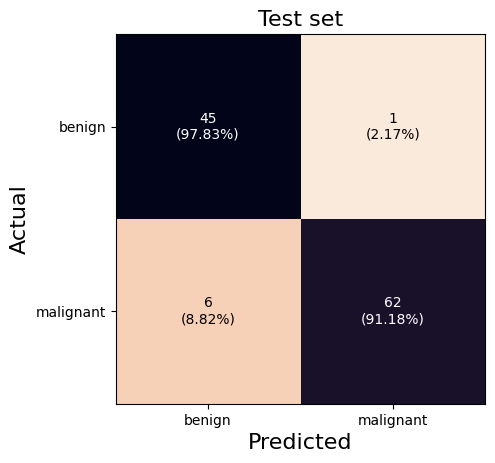

---------------------------------------
AUC validate: 0.9391
AUC test: 0.9450


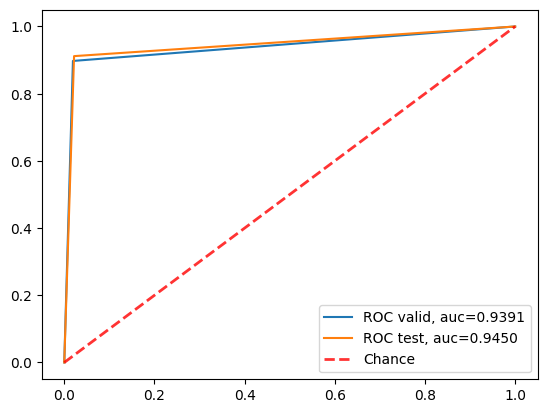

In [10]:
param = 4
param4_split1_cm_val, param4_split1_cm_test, param4_split1_AUC_val, param4_split1_AUC_test = evaluate(param,split)

## param5 split1

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 4 35]] 

----------------
split1
Sensitivity: 89.74%
Specificity: 98.08%
Accuracy: 94.51%
Precision: 97.22%
Sensitivity: 89.74%
Precision: 97.22%
F1: 93.33%


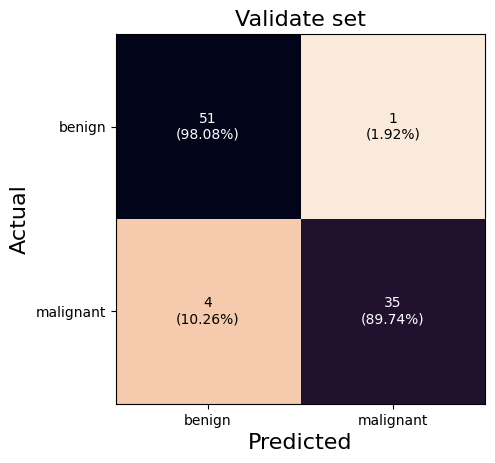

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 6 62]] 

----------------
split1
Sensitivity: 91.18%
Specificity: 97.83%
Accuracy: 93.86%
Precision: 98.41%
Sensitivity: 91.18%
Precision: 98.41%
F1: 94.66%


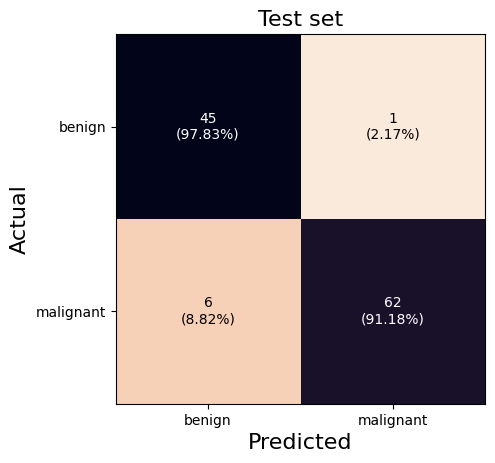

---------------------------------------
AUC validate: 0.9391
AUC test: 0.9450


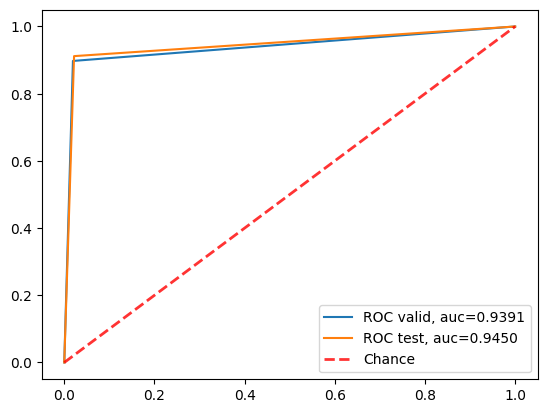

In [11]:
param = 5
param5_split1_cm_val, param5_split1_cm_test, param5_split1_AUC_val, param5_split1_AUC_test = evaluate(param,split)

# Setting Split 2

In [12]:
split_num = 2
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../Anny_oversampling/DATA//split1/train/oversampled_train_split1.csv
(518, 32)
(518, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']
../Anny_oversampling/DATA//split1/val/val_split1.csv
(91, 32)
(91, 30)
['B' 'M']


## param1 split2

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 3 36]] 

----------------
split2
Sensitivity: 92.31%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 92.31%
Precision: 100.00%
F1: 96.00%


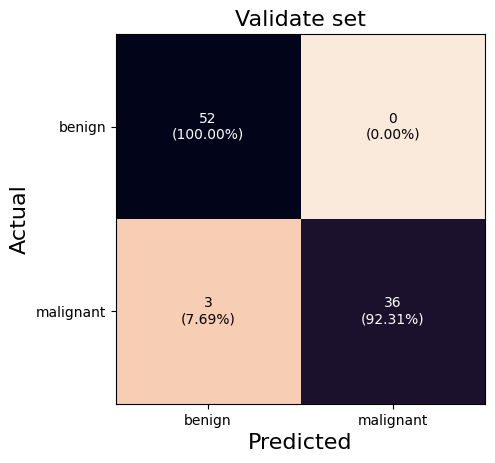

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [10 58]] 

----------------
split2
Sensitivity: 85.29%
Specificity: 97.83%
Accuracy: 90.35%
Precision: 98.31%
Sensitivity: 85.29%
Precision: 98.31%
F1: 91.34%


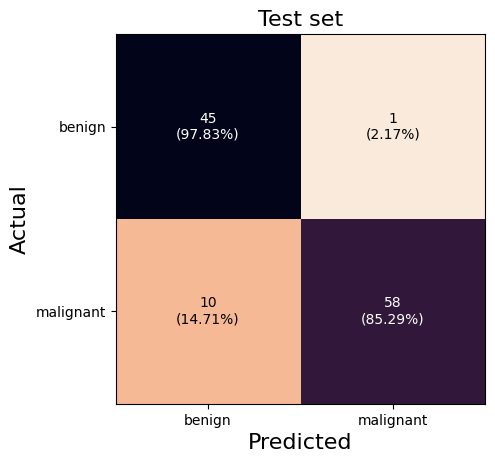

---------------------------------------
AUC validate: 0.9615
AUC test: 0.9156


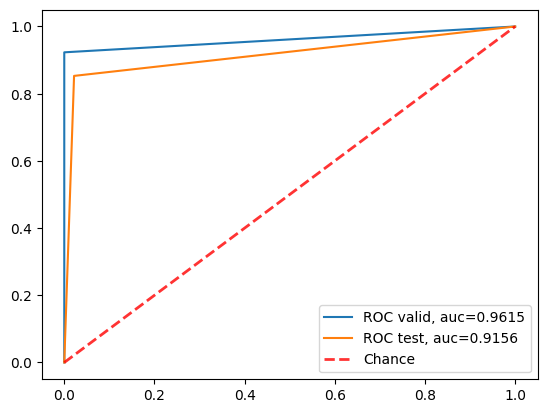

In [13]:
param = 1
param1_split2_cm_val, param1_split2_cm_test, param1_split2_AUC_val, param1_split2_AUC_test = evaluate(param,split)

## param2 split2

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


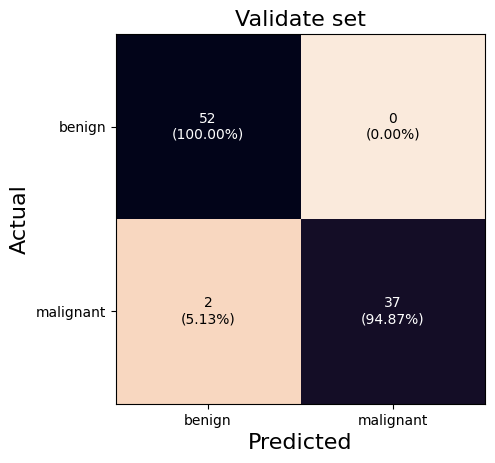

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 9 59]] 

----------------
split2
Sensitivity: 86.76%
Specificity: 97.83%
Accuracy: 91.23%
Precision: 98.33%
Sensitivity: 86.76%
Precision: 98.33%
F1: 92.19%


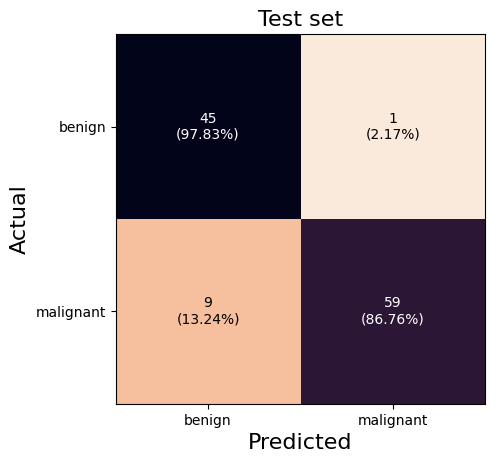

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9230


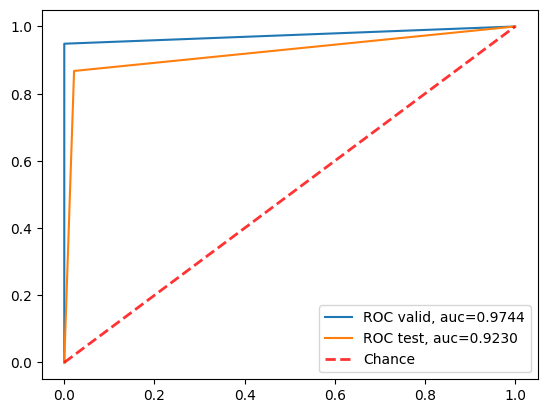

In [14]:
param = 2
param2_split2_cm_val, param2_split2_cm_test, param2_split2_AUC_val, param2_split2_AUC_test = evaluate(param,split)

## param3 split2

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


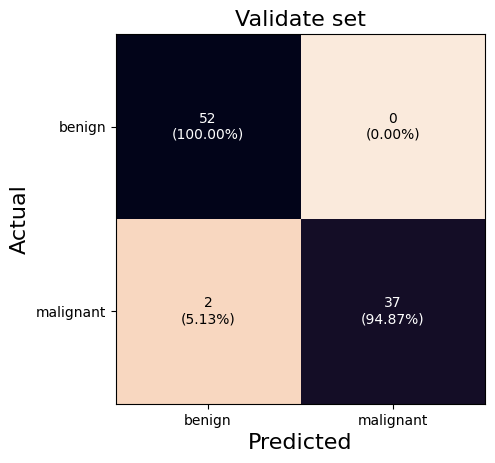

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [11 57]] 

----------------
split2
Sensitivity: 83.82%
Specificity: 100.00%
Accuracy: 90.35%
Precision: 100.00%
Sensitivity: 83.82%
Precision: 100.00%
F1: 91.20%


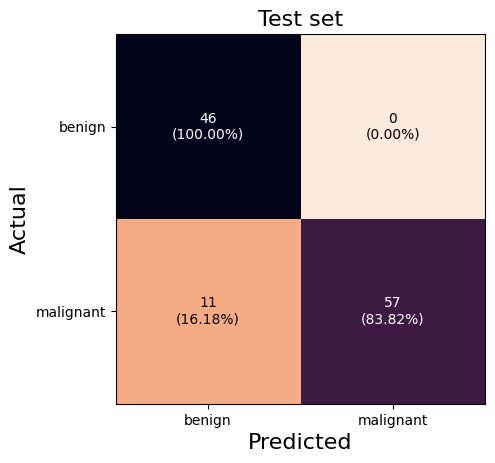

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9191


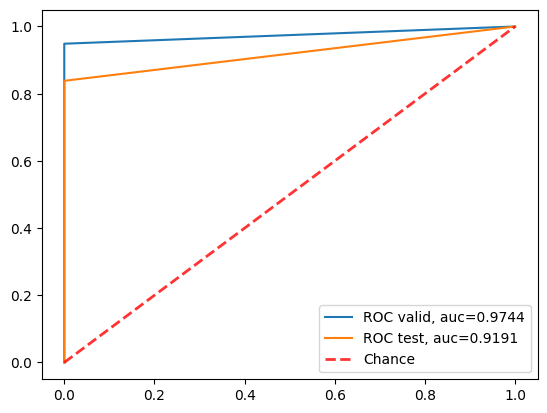

In [15]:
param = 3
param3_split2_cm_val, param3_split2_cm_test, param3_split2_AUC_val, param3_split2_AUC_test = evaluate(param,split)

## param4 split2

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 3 36]] 

----------------
split2
Sensitivity: 92.31%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 92.31%
Precision: 100.00%
F1: 96.00%


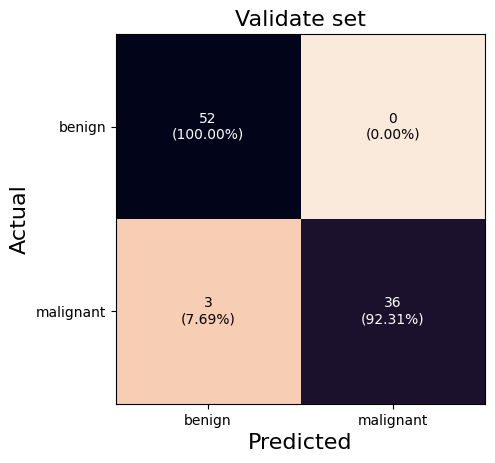

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [13 55]] 

----------------
split2
Sensitivity: 80.88%
Specificity: 100.00%
Accuracy: 88.60%
Precision: 100.00%
Sensitivity: 80.88%
Precision: 100.00%
F1: 89.43%


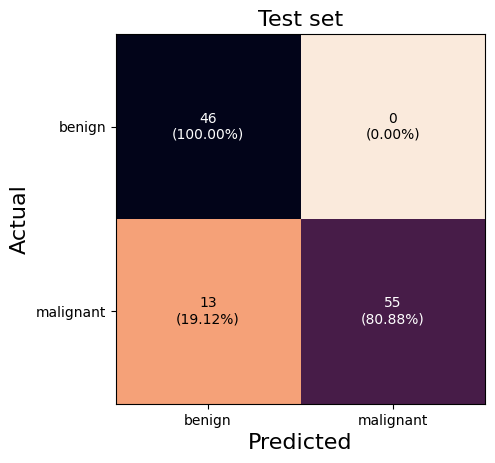

---------------------------------------
AUC validate: 0.9615
AUC test: 0.9044


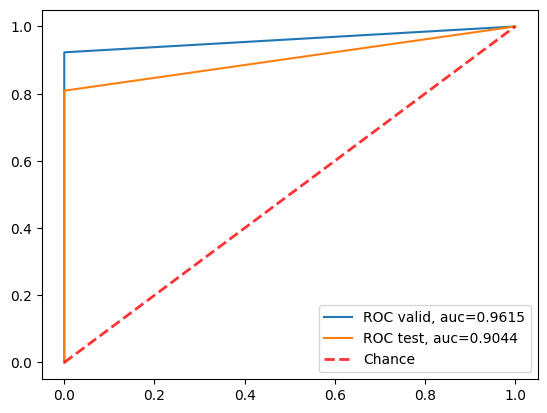

In [16]:
param = 4
param4_split2_cm_val, param4_split2_cm_test, param4_split2_AUC_val, param4_split2_AUC_test = evaluate(param,split)

## param5 split2

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


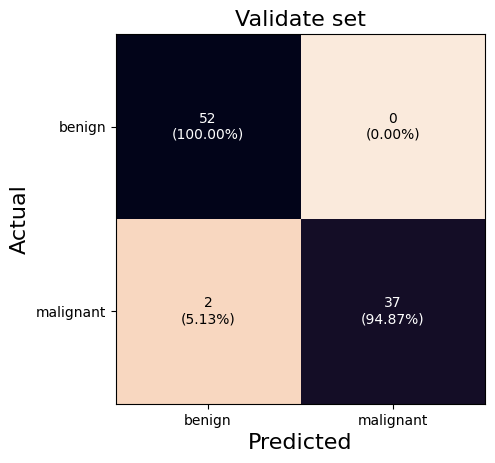

################# test set ##################
Confusion Matrix
----------------
[[46  0]
 [12 56]] 

----------------
split2
Sensitivity: 82.35%
Specificity: 100.00%
Accuracy: 89.47%
Precision: 100.00%
Sensitivity: 82.35%
Precision: 100.00%
F1: 90.32%


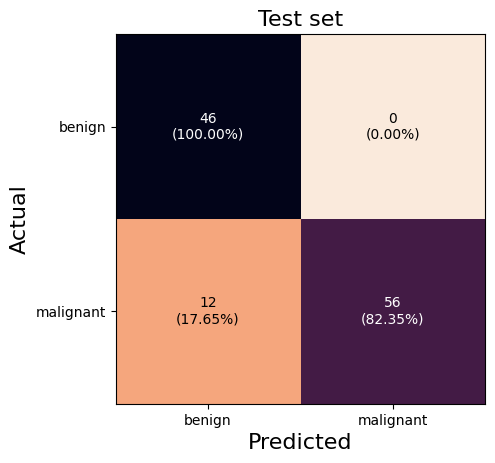

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9118


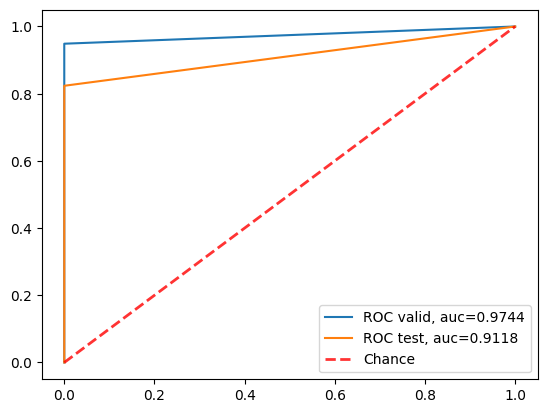

In [17]:
param = 5
param5_split2_cm_val, param5_split2_cm_test, param5_split2_AUC_val, param5_split2_AUC_test = evaluate(param,split)

# Setting Split 3

In [18]:
split_num = 3
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../Anny_oversampling/DATA//split1/train/oversampled_train_split1.csv
(518, 32)
(518, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']
../Anny_oversampling/DATA//split1/val/val_split1.csv
(91, 32)
(91, 30)
['B' 'M']


## param1 split3

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 2 37]] 

----------------
split3
Sensitivity: 94.87%
Specificity: 98.08%
Accuracy: 96.70%
Precision: 97.37%
Sensitivity: 94.87%
Precision: 97.37%
F1: 96.10%


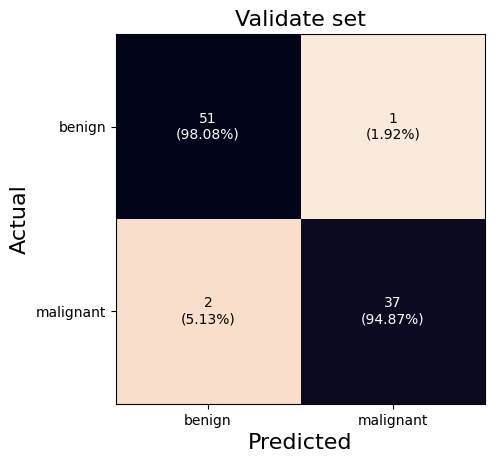

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 9 59]] 

----------------
split3
Sensitivity: 86.76%
Specificity: 95.65%
Accuracy: 90.35%
Precision: 96.72%
Sensitivity: 86.76%
Precision: 96.72%
F1: 91.47%


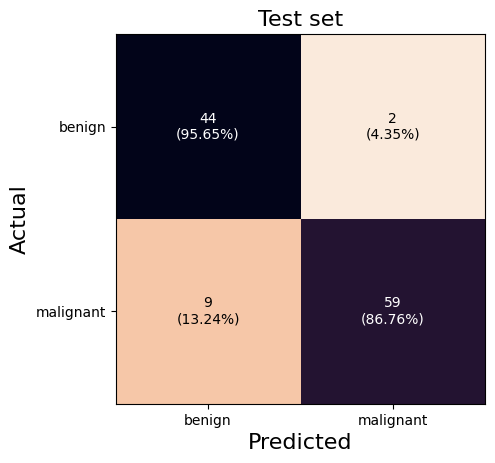

---------------------------------------
AUC validate: 0.9647
AUC test: 0.9121


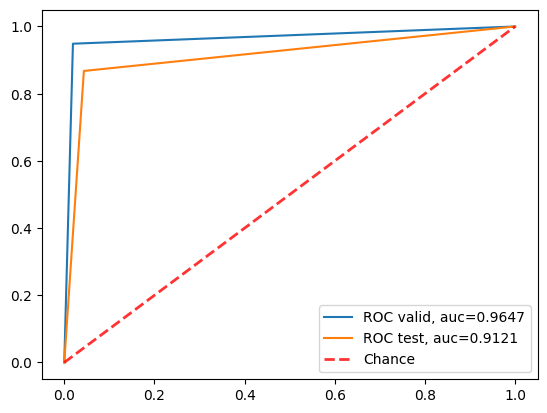

In [19]:
param = 1
param1_split3_cm_val, param1_split3_cm_test, param1_split3_AUC_val, param1_split3_AUC_test = evaluate(param,split)

## param2 split3

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 1 38]] 

----------------
split3
Sensitivity: 97.44%
Specificity: 98.08%
Accuracy: 97.80%
Precision: 97.44%
Sensitivity: 97.44%
Precision: 97.44%
F1: 97.44%


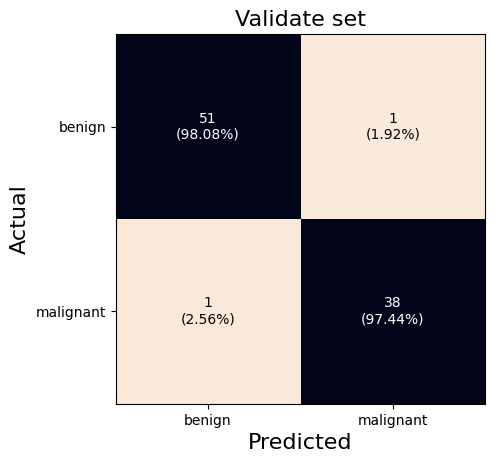

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [10 58]] 

----------------
split3
Sensitivity: 85.29%
Specificity: 97.83%
Accuracy: 90.35%
Precision: 98.31%
Sensitivity: 85.29%
Precision: 98.31%
F1: 91.34%


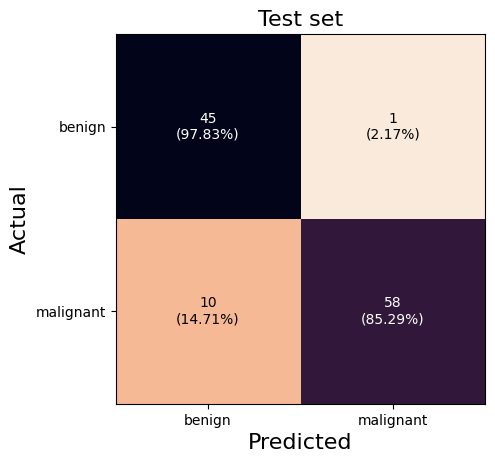

---------------------------------------
AUC validate: 0.9776
AUC test: 0.9156


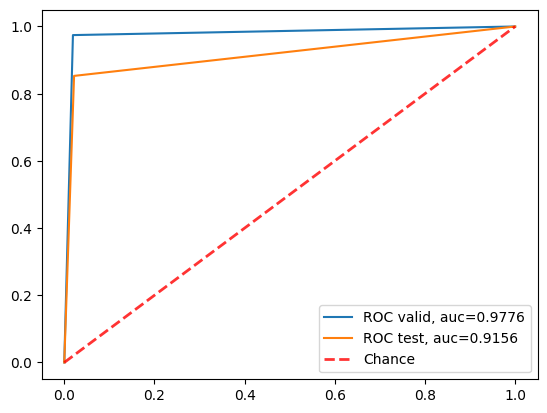

In [20]:
param = 2
param2_split3_cm_val, param2_split3_cm_test, param2_split3_AUC_val, param2_split3_AUC_test = evaluate(param,split)

## param3 split3

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 0 39]] 

----------------
split3
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%


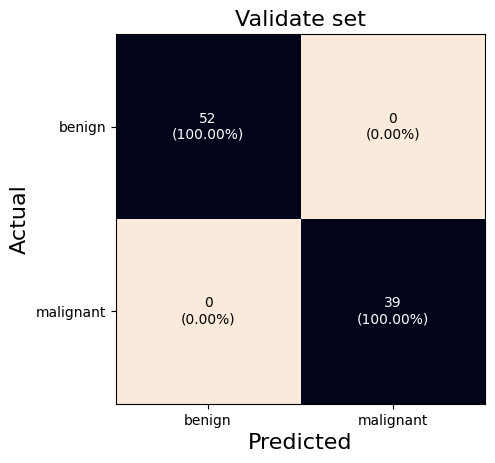

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [10 58]] 

----------------
split3
Sensitivity: 85.29%
Specificity: 97.83%
Accuracy: 90.35%
Precision: 98.31%
Sensitivity: 85.29%
Precision: 98.31%
F1: 91.34%


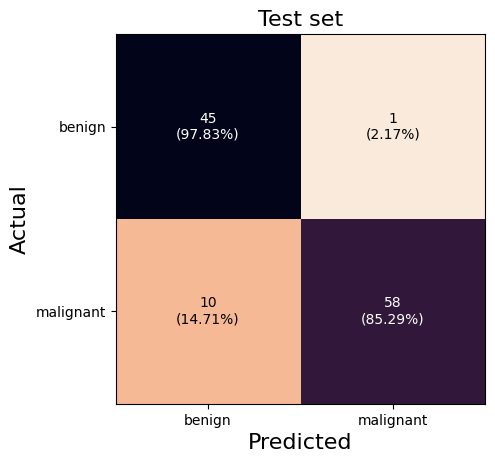

---------------------------------------
AUC validate: 1.0000
AUC test: 0.9156


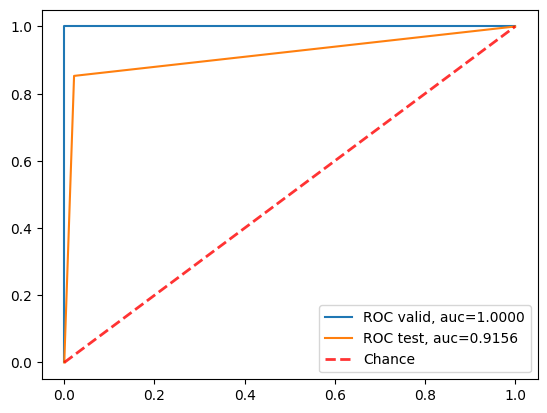

In [21]:
param = 3
param3_split3_cm_val, param3_split3_cm_test, param3_split3_AUC_val, param3_split3_AUC_test = evaluate(param,split)

## param4 split3

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split3
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


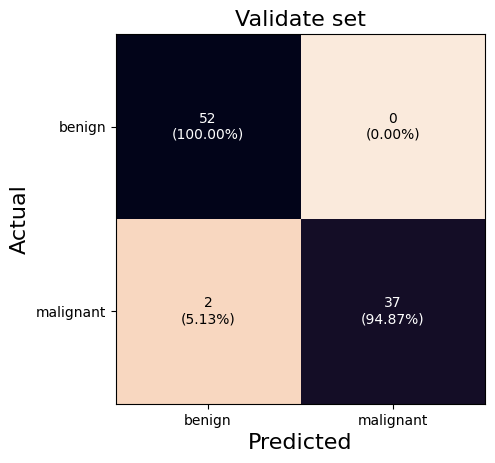

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 9 59]] 

----------------
split3
Sensitivity: 86.76%
Specificity: 97.83%
Accuracy: 91.23%
Precision: 98.33%
Sensitivity: 86.76%
Precision: 98.33%
F1: 92.19%


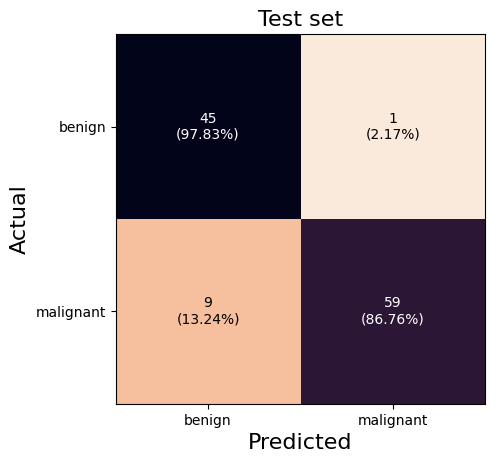

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9230


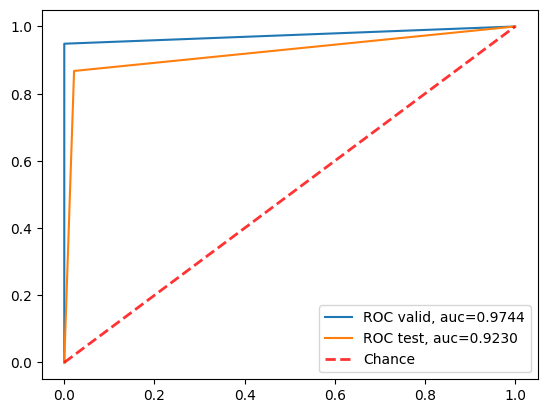

In [22]:
param = 4
param4_split3_cm_val, param4_split3_cm_test, param4_split3_AUC_val, param4_split3_AUC_test = evaluate(param,split)

## param5 split3

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split3
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


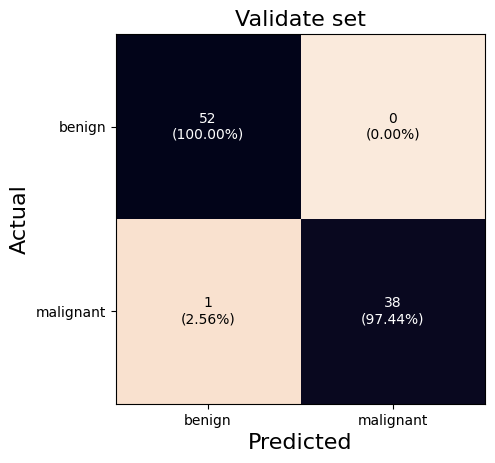

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [10 58]] 

----------------
split3
Sensitivity: 85.29%
Specificity: 97.83%
Accuracy: 90.35%
Precision: 98.31%
Sensitivity: 85.29%
Precision: 98.31%
F1: 91.34%


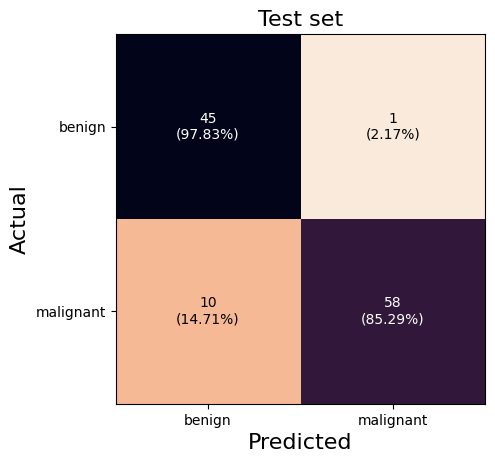

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9156


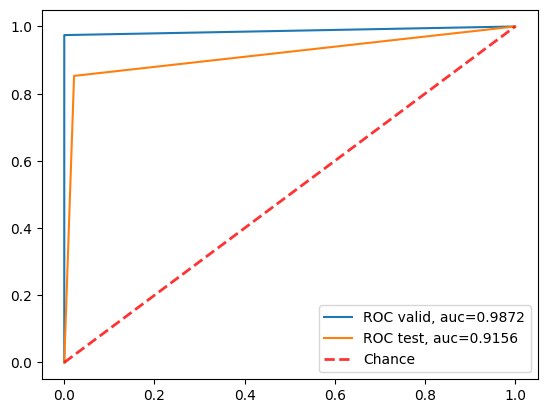

In [23]:
param = 5
param5_split3_cm_val, param5_split3_cm_test, param5_split3_AUC_val, param5_split3_AUC_test = evaluate(param,split)

# Setting Split 4

In [24]:
split_num = 4
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../Anny_oversampling/DATA//split1/train/oversampled_train_split1.csv
(518, 32)
(518, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']
../Anny_oversampling/DATA//split1/val/val_split1.csv
(91, 32)
(91, 30)
['B' 'M']


## param1 split4

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


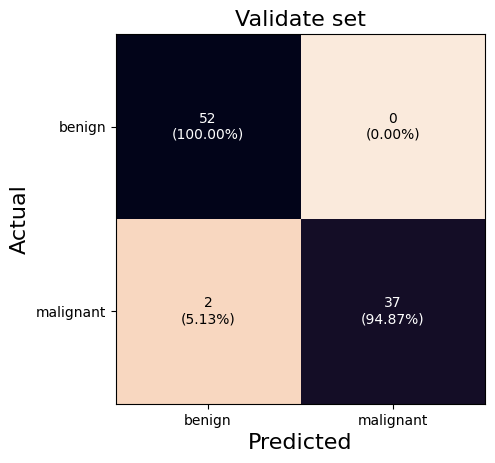

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 7 61]] 

----------------
split4
Sensitivity: 89.71%
Specificity: 95.65%
Accuracy: 92.11%
Precision: 96.83%
Sensitivity: 89.71%
Precision: 96.83%
F1: 93.13%


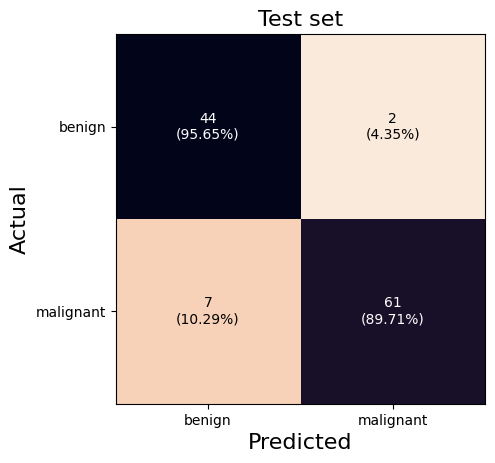

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9268


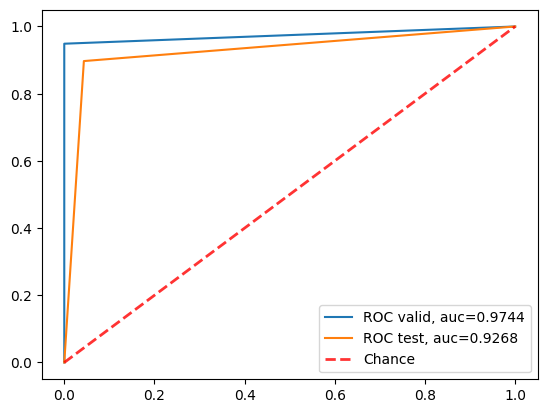

In [25]:
param = 1
param1_split4_cm_val, param1_split4_cm_test, param1_split4_AUC_val, param1_split4_AUC_test = evaluate(param,split)

## param2 split4

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


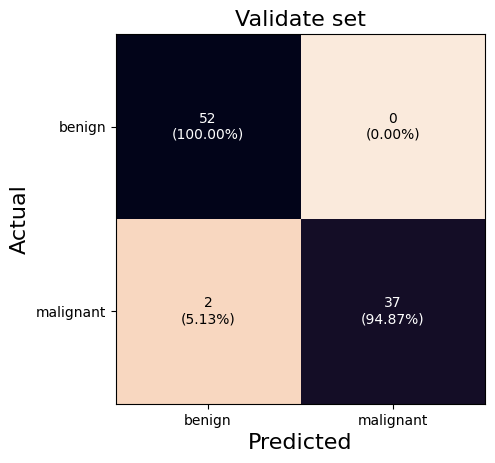

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 7 61]] 

----------------
split4
Sensitivity: 89.71%
Specificity: 95.65%
Accuracy: 92.11%
Precision: 96.83%
Sensitivity: 89.71%
Precision: 96.83%
F1: 93.13%


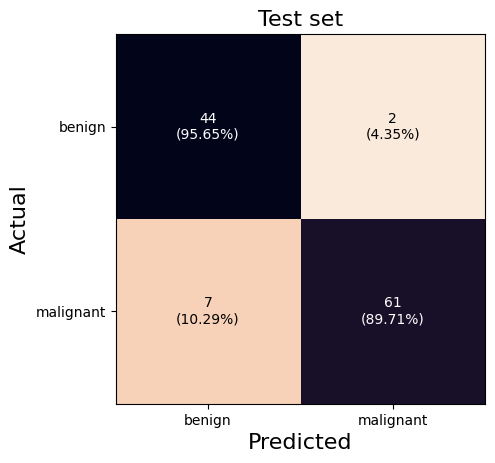

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9268


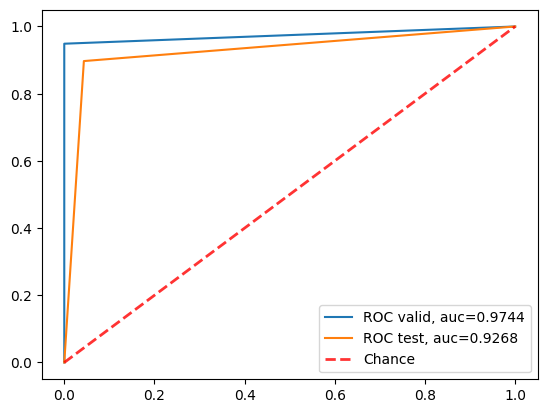

In [26]:
param = 2
param2_split4_cm_val, param2_split4_cm_test, param2_split4_AUC_val, param2_split4_AUC_test = evaluate(param,split)

## param3 split4

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


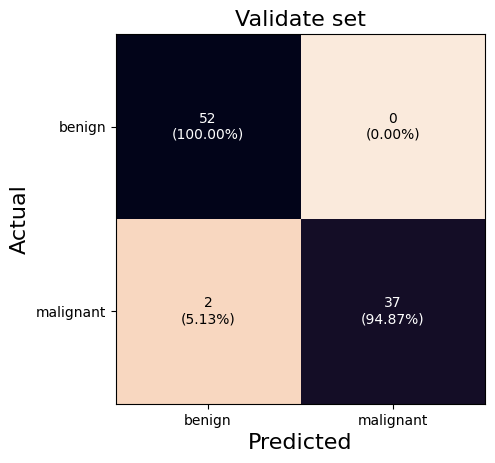

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 7 61]] 

----------------
split4
Sensitivity: 89.71%
Specificity: 97.83%
Accuracy: 92.98%
Precision: 98.39%
Sensitivity: 89.71%
Precision: 98.39%
F1: 93.85%


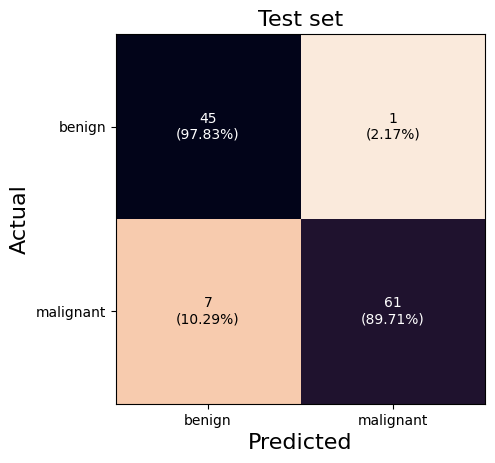

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9377


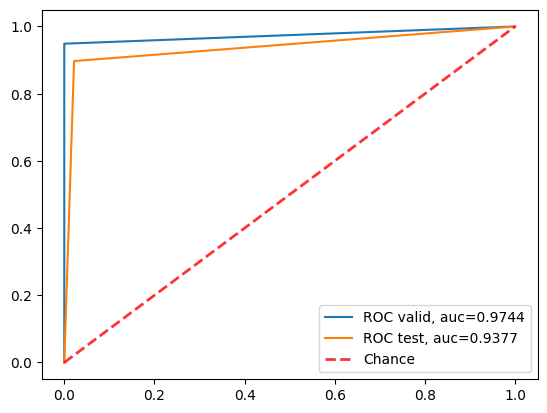

In [27]:
param = 3
param3_split4_cm_val, param3_split4_cm_test, param3_split4_AUC_val, param3_split4_AUC_test = evaluate(param,split)

## param4 split4

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 2 37]] 

----------------
split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%


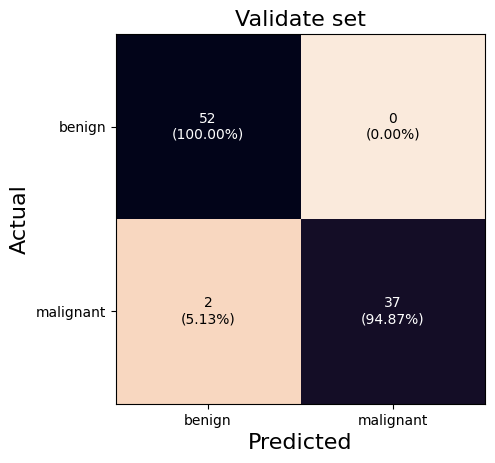

################# test set ##################
Confusion Matrix
----------------
[[44  2]
 [ 6 62]] 

----------------
split4
Sensitivity: 91.18%
Specificity: 95.65%
Accuracy: 92.98%
Precision: 96.88%
Sensitivity: 91.18%
Precision: 96.88%
F1: 93.94%


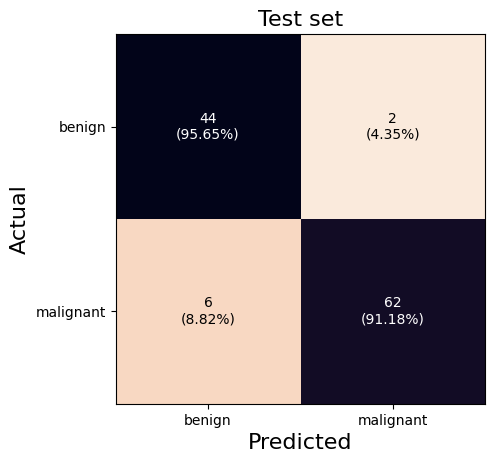

---------------------------------------
AUC validate: 0.9744
AUC test: 0.9341


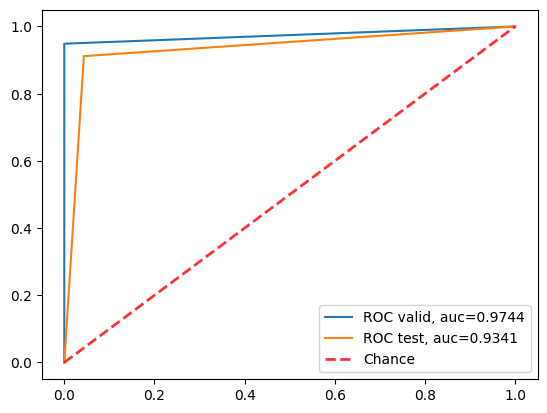

In [28]:
param = 4
param4_split4_cm_val, param4_split4_cm_test, param4_split4_AUC_val, param4_split4_AUC_test = evaluate(param,split)

## param5 split4

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split4
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


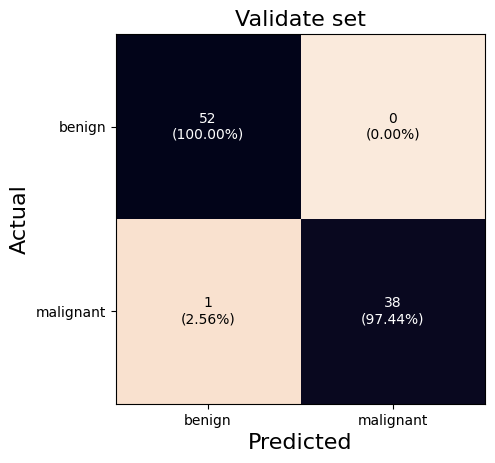

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 8 60]] 

----------------
split4
Sensitivity: 88.24%
Specificity: 97.83%
Accuracy: 92.11%
Precision: 98.36%
Sensitivity: 88.24%
Precision: 98.36%
F1: 93.02%


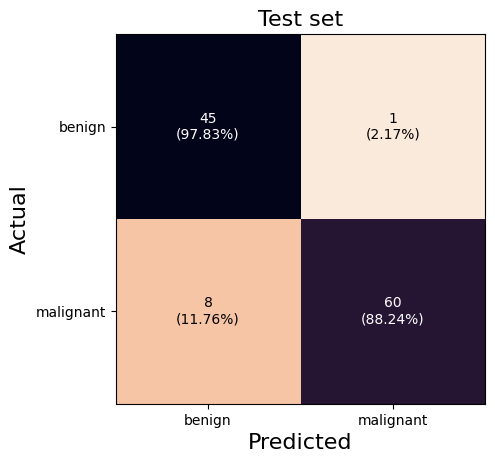

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9303


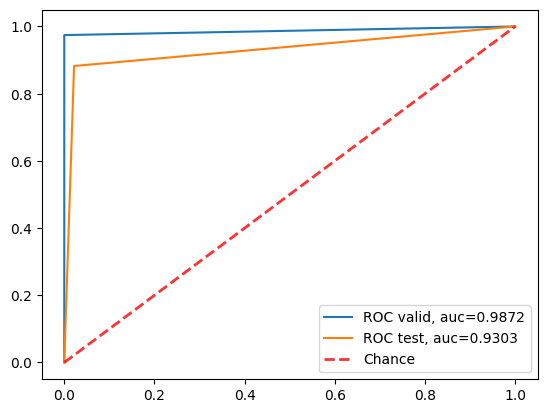

In [29]:
param = 5
param5_split4_cm_val, param5_split4_cm_test, param5_split4_AUC_val, param5_split4_AUC_test = evaluate(param,split)

# Setting Split 5

In [30]:
split_num = 5
split = "split{}".format(split_num)
x_train,y_train,x_test,y_test,x_val,y_val = setup(split)

../Anny_oversampling/DATA//split1/train/oversampled_train_split1.csv
(518, 32)
(518, 30)
['B' 'M']
../Anny_oversampling/DATA//test.csv
(114, 33)
(114, 30)
['B' 'M']
../Anny_oversampling/DATA//split1/val/val_split1.csv
(91, 32)
(91, 30)
['B' 'M']


## param1 split5

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


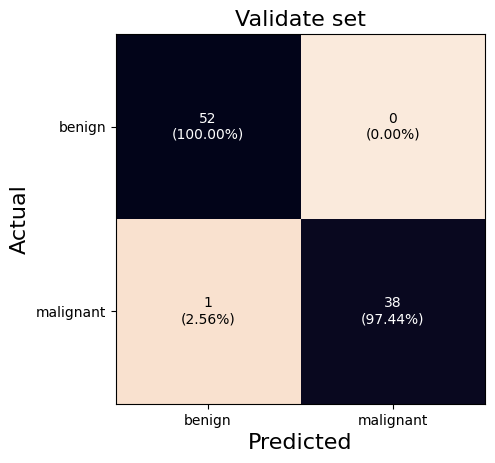

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [11 57]] 

----------------
split5
Sensitivity: 83.82%
Specificity: 97.83%
Accuracy: 89.47%
Precision: 98.28%
Sensitivity: 83.82%
Precision: 98.28%
F1: 90.48%


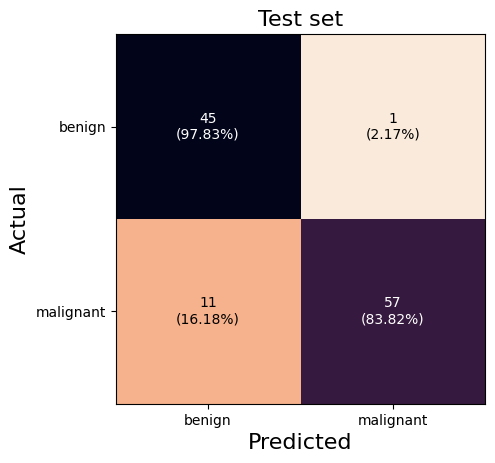

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9082


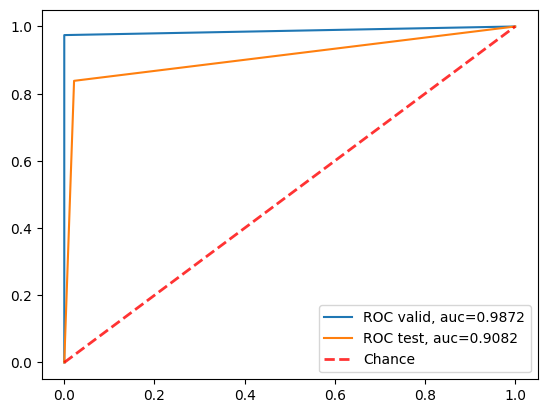

In [31]:
param = 1
param1_split5_cm_val, param1_split5_cm_test, param1_split5_AUC_val, param1_split5_AUC_test = evaluate(param,split)

## param2 split5

############## validate set ################
Confusion Matrix
----------------
[[51  1]
 [ 1 38]] 

----------------
split5
Sensitivity: 97.44%
Specificity: 98.08%
Accuracy: 97.80%
Precision: 97.44%
Sensitivity: 97.44%
Precision: 97.44%
F1: 97.44%


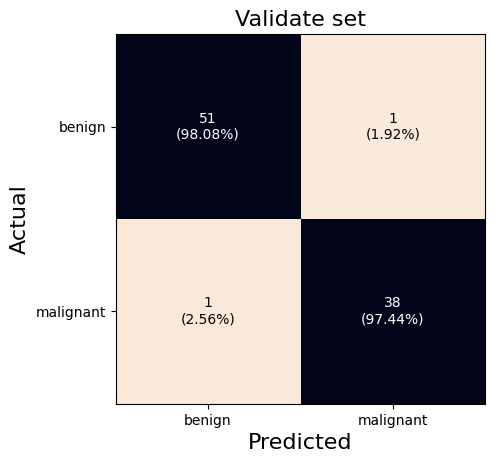

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 9 59]] 

----------------
split5
Sensitivity: 86.76%
Specificity: 97.83%
Accuracy: 91.23%
Precision: 98.33%
Sensitivity: 86.76%
Precision: 98.33%
F1: 92.19%


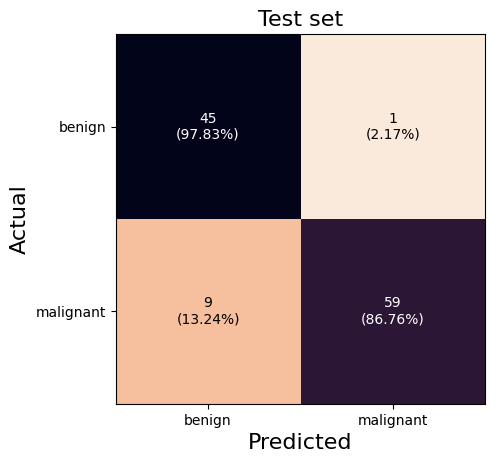

---------------------------------------
AUC validate: 0.9776
AUC test: 0.9230


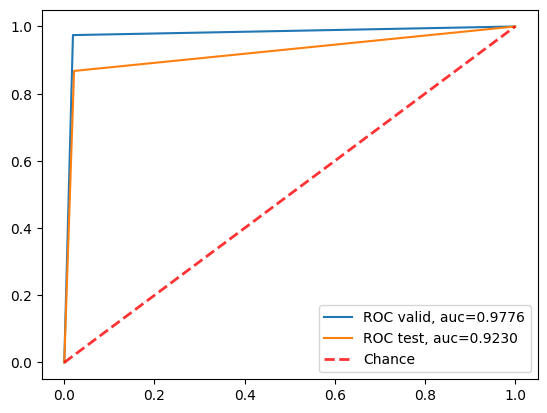

In [32]:
param = 2
param2_split5_cm_val, param2_split5_cm_test, param2_split5_AUC_val, param2_split5_AUC_test = evaluate(param,split)

## param3 split5

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


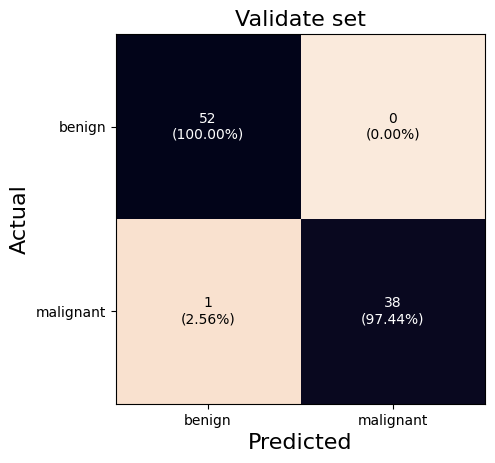

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 9 59]] 

----------------
split5
Sensitivity: 86.76%
Specificity: 97.83%
Accuracy: 91.23%
Precision: 98.33%
Sensitivity: 86.76%
Precision: 98.33%
F1: 92.19%


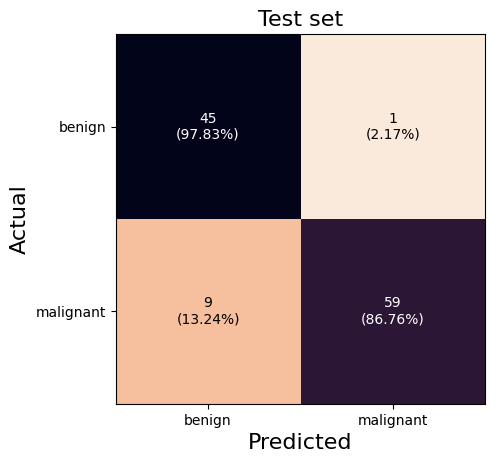

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9230


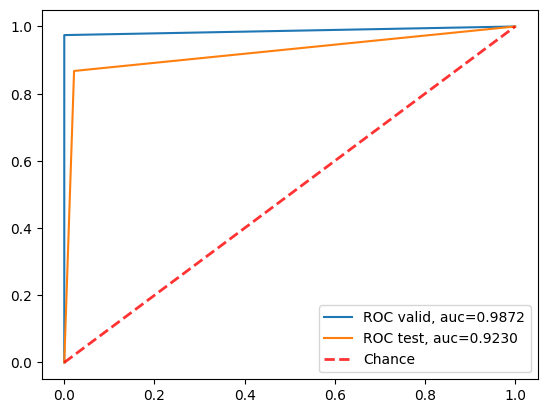

In [33]:
param = 3
param3_split5_cm_val, param3_split5_cm_test, param3_split5_AUC_val, param3_split5_AUC_test = evaluate(param,split)

## param4 split5

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


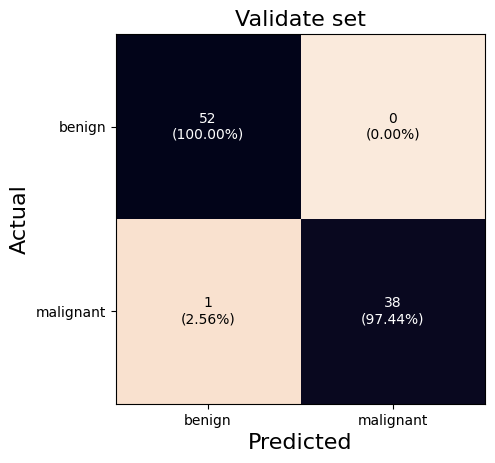

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [ 9 59]] 

----------------
split5
Sensitivity: 86.76%
Specificity: 97.83%
Accuracy: 91.23%
Precision: 98.33%
Sensitivity: 86.76%
Precision: 98.33%
F1: 92.19%


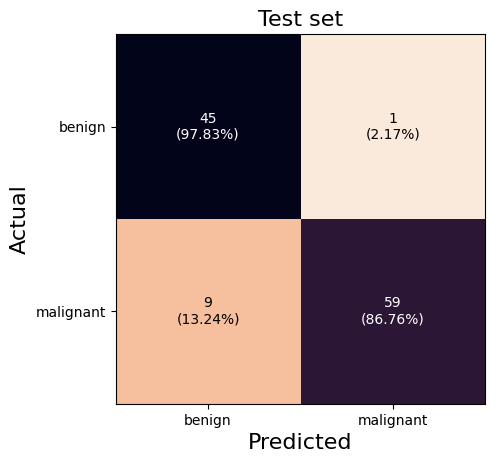

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9230


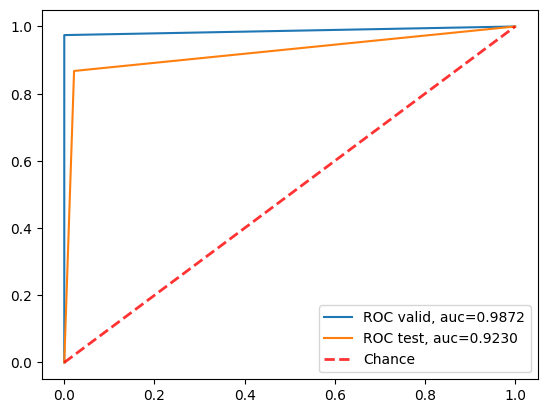

In [34]:
param = 4
param4_split5_cm_val, param4_split5_cm_test, param4_split5_AUC_val, param4_split5_AUC_test = evaluate(param,split)

## param5 split5

############## validate set ################
Confusion Matrix
----------------
[[52  0]
 [ 1 38]] 

----------------
split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%


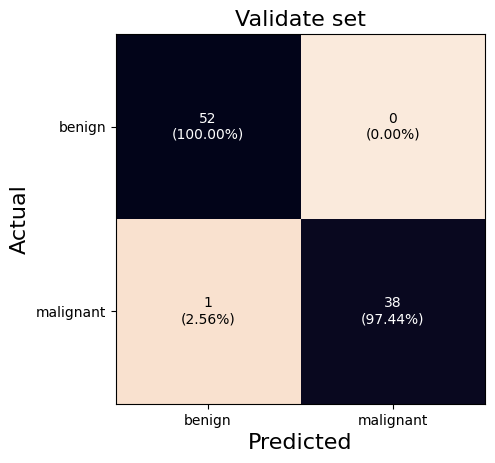

################# test set ##################
Confusion Matrix
----------------
[[45  1]
 [10 58]] 

----------------
split5
Sensitivity: 85.29%
Specificity: 97.83%
Accuracy: 90.35%
Precision: 98.31%
Sensitivity: 85.29%
Precision: 98.31%
F1: 91.34%


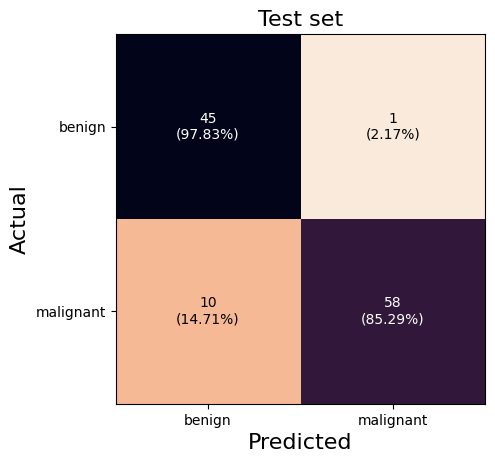

---------------------------------------
AUC validate: 0.9872
AUC test: 0.9156


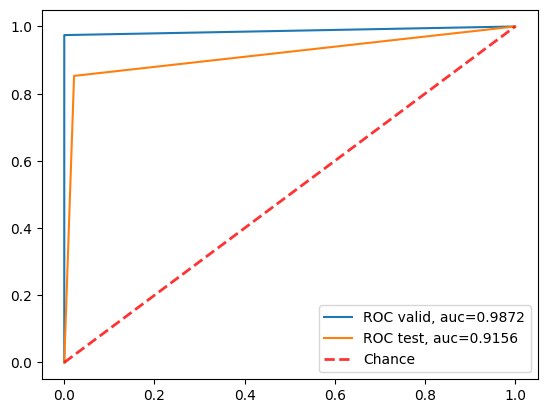

In [35]:
param = 5
param5_split5_cm_val, param5_split5_cm_test, param5_split5_AUC_val, param5_split5_AUC_test = evaluate(param,split)

# overall

In [36]:
def Mean_SD(name,split1, split2, split3, split4, split5):
    sensitivity_values = []
    sensitivity_values.append(split1)
    sensitivity_values.append(split2)
    sensitivity_values.append(split3)
    sensitivity_values.append(split4)
    sensitivity_values.append(split5)

    # calculating the mean of sample set
    mean_sensitivity = statistics.mean(sensitivity_values)
    # Calculate standard deviation of sensitivity
    sensitivity_sd = statistics.stdev(sensitivity_values)
    
    # Print mean sensitivity with standard deviation
    print("%s: %.2f ± %.2f%%" % (name,mean_sensitivity, sensitivity_sd))

In [37]:
def plot(split1_cm, split2_cm, split3_cm, split4_cm, split5_cm):
    cm_val = split1_cm + split2_cm + split3_cm + split4_cm + split5_cm
    # Calculate score
    print("split1")
    sen_val_1 = sensitivity(split1_cm)
    spec_val_1 = specificity(split1_cm)
    acc_val_1 = accuracy(split1_cm)
    pre_val_1 = precision(split1_cm)
    f1_score_val_1 = f1(split1_cm)
    print("\nsplit2")
    sen_val_2 = sensitivity(split2_cm)
    spec_val_2 = specificity(split2_cm)
    acc_val_2 = accuracy(split2_cm)
    pre_val_2 = precision(split2_cm)
    f1_score_val_2 = f1(split2_cm)
    print("\nsplit3")
    sen_val_3 = sensitivity(split3_cm)
    spec_val_3 = specificity(split3_cm)
    acc_val_3 = accuracy(split3_cm)
    pre_val_3 = precision(split3_cm)
    f1_score_val_3 = f1(split3_cm)
    print("\nsplit4")
    sen_val_4 = sensitivity(split4_cm)
    spec_val_4 = specificity(split4_cm)
    acc_val_4 = accuracy(split4_cm)
    pre_val_4 = precision(split4_cm)
    f1_score_val_4 = f1(split4_cm)
    print("\nsplit5")
    sen_val_5 = sensitivity(split5_cm)
    spec_val_5 = specificity(split5_cm)
    acc_val_5 = accuracy(split5_cm)
    pre_val_5 = precision(split5_cm)
    f1_score_val_5 = f1(split5_cm)
    print("\noverall")
    Mean_SD("sensitivity",sen_val_1, sen_val_2, sen_val_3, sen_val_4, sen_val_5)
    Mean_SD("specificity",spec_val_1, spec_val_2, spec_val_3, spec_val_4, spec_val_5)
    Mean_SD("accuracy",acc_val_1, acc_val_2, acc_val_3, acc_val_4, acc_val_5)
    Mean_SD("precision",pre_val_1, pre_val_2, pre_val_3, pre_val_4, pre_val_5)
    Mean_SD("f1_score",f1_score_val_1, f1_score_val_2, f1_score_val_3, f1_score_val_4, f1_score_val_5)
    # plot confusion matrix
    class_names = ['benign','malignant']
    # Normalize confusion matrix to percentage
    cm_norm_val = cm_val.astype('float') / cm_val.sum(axis=1)[:, np.newaxis]
    # Create plot
    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm_val, interpolation='nearest', cmap="rocket_r")
    ax.grid(False)
    # Add labels
    ax.set(xticks=np.arange(cm_norm_val.shape[1]),
           yticks=np.arange(cm_norm_val.shape[0]),
           xticklabels=class_names, yticklabels=class_names)
    ax.set_title("Validate set", fontsize=16)
    ax.set_ylabel('Actual', fontsize=16)
    ax.set_xlabel('Predicted', fontsize=16)
    # Add percentage and count values inside plot
    thresh = cm_norm_val.max() / 2.
    for i in range(cm_norm_val.shape[0]):
        for j in range(cm_norm_val.shape[1]):
            ax.text(j, i, '''{}\n({:.2f}%)'''.format(cm_val[i,j], cm_norm_val[i, j]*100),
                    ha="center", va="center",
                    color="white" if cm_norm_val[i, j] > thresh else "black")
    # plt.savefig('rf_model/validate_cm_{}.png'.format(split))
    # plt.savefig('rf_model/validate_cm_best_param2_{}.png'.format(split))
    plt.show()

## overall param1

param1
split1
Sensitivity: 92.31%
Specificity: 96.15%
Accuracy: 94.51%
Precision: 94.74%
Sensitivity: 92.31%
Precision: 94.74%
F1: 93.51%

split2
Sensitivity: 92.31%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 92.31%
Precision: 100.00%
F1: 96.00%

split3
Sensitivity: 94.87%
Specificity: 98.08%
Accuracy: 96.70%
Precision: 97.37%
Sensitivity: 94.87%
Precision: 97.37%
F1: 96.10%

split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

overall
sensitivity: 94.36 ± 2.15%
specificity: 98.85 ± 1.72%
accuracy: 96.92 ± 1.63%
precision: 98.42 ± 2.35%
f1_score: 96.34 ± 1.93%


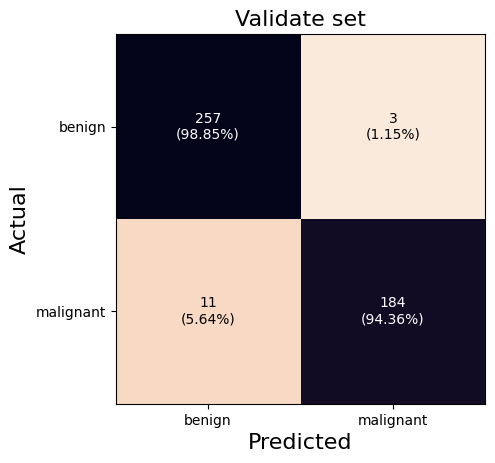

In [38]:
print("param1")
plot(param1_split1_cm_val , param1_split2_cm_val , param1_split3_cm_val , param1_split4_cm_val , param1_split5_cm_val)
Mean_SD("AUC",param1_split1_AUC_val, param1_split2_AUC_val, param1_split3_AUC_val, param1_split4_AUC_val, param1_split5_AUC_val)

## overall param2

param2
split1
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%

split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split3
Sensitivity: 97.44%
Specificity: 98.08%
Accuracy: 97.80%
Precision: 97.44%
Sensitivity: 97.44%
Precision: 97.44%
F1: 97.44%

split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split5
Sensitivity: 97.44%
Specificity: 98.08%
Accuracy: 97.80%
Precision: 97.44%
Sensitivity: 97.44%
Precision: 97.44%
F1: 97.44%

overall
sensitivity: 95.38 ± 2.15%
specificity: 98.85 ± 1.05%
accuracy: 97.36 ± 0.98%
precision: 98.43 ± 1.43%
f1_score: 96.87 ± 1.19%


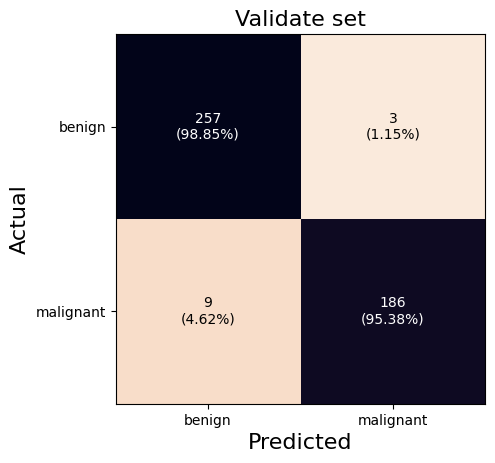

In [39]:
print("param2")
plot(param2_split1_cm_val , param2_split2_cm_val , param2_split3_cm_val , param2_split4_cm_val , param2_split5_cm_val)
Mean_SD("AUC",param1_split1_AUC_val, param1_split2_AUC_val, param1_split3_AUC_val, param1_split4_AUC_val, param1_split5_AUC_val)

## overall param3

param3
split1
Sensitivity: 92.31%
Specificity: 98.08%
Accuracy: 95.60%
Precision: 97.30%
Sensitivity: 92.31%
Precision: 97.30%
F1: 94.74%

split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split3
Sensitivity: 100.00%
Specificity: 100.00%
Accuracy: 100.00%
Precision: 100.00%
Sensitivity: 100.00%
Precision: 100.00%
F1: 100.00%

split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

overall
sensitivity: 95.90 ± 2.92%
specificity: 99.62 ± 0.86%
accuracy: 98.02 ± 1.63%
precision: 99.46 ± 1.21%
f1_score: 97.63 ± 1.95%


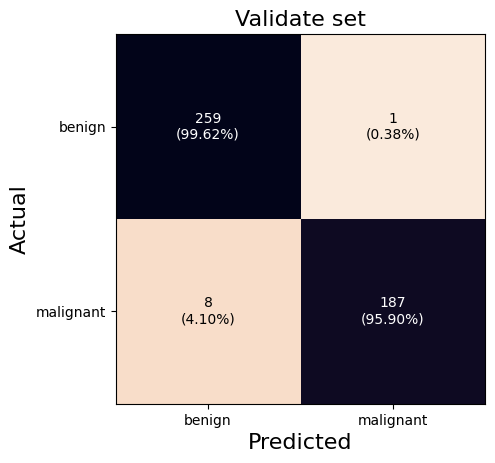

In [40]:
print("param3")
plot(param3_split1_cm_val , param3_split2_cm_val , param3_split3_cm_val , param3_split4_cm_val , param3_split5_cm_val)

## overall param4

param4
split1
Sensitivity: 89.74%
Specificity: 98.08%
Accuracy: 94.51%
Precision: 97.22%
Sensitivity: 89.74%
Precision: 97.22%
F1: 93.33%

split2
Sensitivity: 92.31%
Specificity: 100.00%
Accuracy: 96.70%
Precision: 100.00%
Sensitivity: 92.31%
Precision: 100.00%
F1: 96.00%

split3
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split4
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

overall
sensitivity: 93.85 ± 2.92%
specificity: 99.62 ± 0.86%
accuracy: 97.14 ± 1.67%
precision: 99.44 ± 1.24%
f1_score: 96.55 ± 2.04%


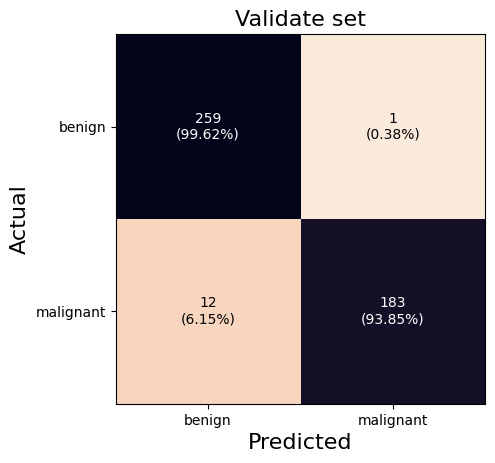

In [41]:
print("param4")
plot(param4_split1_cm_val , param4_split2_cm_val , param4_split3_cm_val , param4_split4_cm_val , param4_split5_cm_val)

## overall param5

param5
split1
Sensitivity: 89.74%
Specificity: 98.08%
Accuracy: 94.51%
Precision: 97.22%
Sensitivity: 89.74%
Precision: 97.22%
F1: 93.33%

split2
Sensitivity: 94.87%
Specificity: 100.00%
Accuracy: 97.80%
Precision: 100.00%
Sensitivity: 94.87%
Precision: 100.00%
F1: 97.37%

split3
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

split4
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

split5
Sensitivity: 97.44%
Specificity: 100.00%
Accuracy: 98.90%
Precision: 100.00%
Sensitivity: 97.44%
Precision: 100.00%
F1: 98.70%

overall
sensitivity: 95.38 ± 3.34%
specificity: 99.62 ± 0.86%
accuracy: 97.80 ± 1.90%
precision: 99.44 ± 1.24%
f1_score: 97.36 ± 2.32%


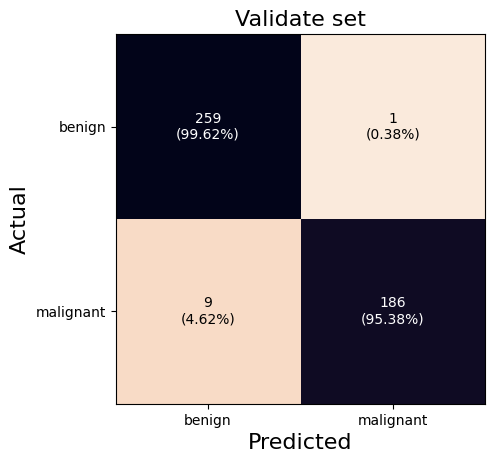

In [42]:
print("param5")
plot(param5_split1_cm_val , param5_split2_cm_val , param5_split3_cm_val , param5_split4_cm_val , param5_split5_cm_val)